In [116]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Cargar el conjunto de datos
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist['data'] / 255, mnist['target']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 3, random_state=42)
n = X_train.shape[0]
print(f"Rows to train: {n}")
m = X_test.shape[0]
print(f"Rows to test: {m}")

# Parámetros de la red neuronal
L = 0.02  # Tasa de aprendizaje
num_iterations = 4_000
batch_size = 1024

# Preguntar al usuario si desea cargar los parámetros antiguos o entrenar desde cero
user_choice = input("Cargar parametros antiguos (c) o entrenar desde cero (e)? ")

#! Inicializar los parametros de la red neuronal ===============================================

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final precision of test: 67.2851%, Final Precision of train: 72.3632%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final precision of test: 90.5761%, Final Precision of train: 97.9492%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final precision of test: 44.2382%, Final Precision of train: 44.0429%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final precision of test: 90.9175%, Final Precision of train: 100.0000%, se creo a partir de params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final precision of test: 91.2597%, Final Precision of train: 100.0000%, se creo a partir de params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final precision of test: 93.8964%, Final Precision of train: 100.0000%, se creo a partir de params_4
model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final precision of test: 94.8730%, Final Precision of train: 100.0000%, se creo a partir de params_5
#model_params_file = os.path.join('Weights_&_Bias', 'params_7.npz') # Final precision of test: 70.3125%, Final Precision of train: 100.0000%, L = 0.01, batch_size = 128, num_iterations = 10_000, si queres saber a que grafico corresponde mira el titulo del graph
#model_params_file = os.path.join('Weights_&_Bias', 'params_8.npz') # Final precision of test: 76.5625%, Final Precision of train: 100.0000%, L = 0.02, batch_size = 256, num_iterations = 8_000
#model_params_file = os.path.join('Weights_&_Bias', 'params_9.npz') # Final precision of test: 86.7188%, Final Precision of train: 99.1211%, L = 0.02, batch_size = 256, num_iterations= 4_000

#! Inicializar los parametros de la red neuronal ===============================================

# Inicializar pesos y bias
if user_choice.lower() == 'c' and os.path.exists(model_params_file):
    # Cargar los pesos y los bias desde el archivo .npz
    try:
        params = np.load(model_params_file)
        w_1 = params['w_1']
        b_1 = params['b_1']
        w_2 = params['w_2']
        b_2 = params['b_2']
        w_3 = params['w_3']
        b_3 = params['b_3']
        print(f"Parametros cargados desde '{model_params_file}'.")
    except Exception as e:
        print(f"Error al cargar parametros: {e}")
        # Inicializar aleatoriamente si hay un error
        np.random.seed(13)
        w_1 = np.random.randn(256, 784) * 0.01
        w_2 = np.random.randn(128, 256) * 0.01
        w_3 = np.random.randn(10, 128) * 0.01
        b_1 = np.random.rand(256, 1)
        b_2 = np.random.rand(128, 1)
        b_3 = np.random.rand(10, 1)
        print("Parametros inicializados aleatoriamente.")
else:
    # Inicializar aleatoriamente los pesos y bias
    np.random.seed(13)
    w_1 = np.random.randn(256, 784) * 0.01
    w_2 = np.random.randn(128, 256) * 0.01
    w_3 = np.random.randn(10, 128) * 0.01
    b_1 = np.random.rand(256, 1)
    b_2 = np.random.rand(128, 1)
    b_3 = np.random.rand(10, 1)
    print("Parametros inicializados aleatoriamente.")

# Funciones de activación
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Derivadas de las funciones de activación
d_relu = lambda x: x > 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y.astype(int), np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    # Convertir Y a codificación one-hot
    one_hot_Y = one_hot(Y, A3.shape[0])
    
    dCE_dZ3 = A3 - one_hot_Y
    dZ3_dW3 = A2  
    dZ3_dB3 = 1
    dZ3_dA2 = w_3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dZ2_dA1 = w_2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    # Calcular gradientes para W3 y b3
    dCE_dW3 = dCE_dZ3 @ dZ3_dW3.T / X.shape[1]
    dCE_dB3 = np.sum(dCE_dZ3, axis=1, keepdims=True) / X.shape[1]

    dCE_dA2 = dZ3_dA2.T @ dCE_dZ3
    dCE_dZ2 = dCE_dA2 * dA2_dZ2

    # Calcular gradientes para W2 y b2
    dCE_dW2 = dCE_dZ2 @ dZ2_dW2.T / X.shape[1]
    dCE_dB2 = np.sum(dCE_dZ2, axis=1, keepdims=True) / X.shape[1]

    dCE_dA1 = dZ2_dA1.T @ dCE_dZ2
    dCE_dZ1 = dCE_dA1 * dA1_dZ1

    # Calcular gradientes para W1 y b1
    dCE_dW1 = dCE_dZ1 @ dZ1_dW1.T / X.shape[1]
    dCE_dB1 = np.sum(dCE_dA1, axis=1, keepdims=True) / X.shape[1]

    return dCE_dW1, dCE_dB1, dCE_dW2, dCE_dB2, dCE_dW3, dCE_dB3

def calculate_accuracy(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

# Entrenamiento por descenso de gradiente
accuracy_train_l = []
accuracy_test_l = []
for i in tqdm(range(num_iterations), desc="Training", unit="iteration"):
    np.random.seed(13)
    idx = np.random.choice(n, batch_size, replace=False)
    X_train_sample = X_train.iloc[idx].to_numpy().transpose()  # Transponer a (784, batch_size)
    Y_train_sample = Y_train.iloc[idx].to_numpy()
    #print(X_train_sample.shape)
    #print(Y_train_sample.shape)
    
    idx = np.random.choice(m, batch_size, replace=False)
    X_test_sample = X_test.iloc[idx].to_numpy().transpose()  # Transponer a (784, batch_size)
    Y_test_sample = Y_test.iloc[idx].to_numpy()
    #print(X_test_sample.shape)
    #print(Y_test_sample.shape)
    
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_train_sample)

    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_train_sample, Y_train_sample)

    # Actualizar pesos y bias
    w_1 -= L * dW1
    b_1 -= L * dB1
    w_2 -= L * dW2
    b_2 -= L * dB2
    w_3 -= L * dW3
    b_3 -= L * dB3

    # Calcular precisión del conjunto de prueba
    _, _, _, _, _, A3_test = forward_prop(X_test_sample)
    test_predictions = np.argmax(A3_test, axis=0)
    accuracy_test = np.mean(test_predictions == Y_test_sample.astype(int))
    accuracy_test_l.append(accuracy_test)

    # Calcular precisión del conjunto de entrenamiento
    _, _, _, _, _, A3_train = forward_prop(X_train_sample)
    train_predictions = np.argmax(A3_train, axis=0)
    accuracy_train = np.mean(train_predictions == Y_train_sample.astype(int))
    accuracy_train_l.append(accuracy_train)
    if i % 200 == 0:
        print(f"Iter {i}, Precision of test: {accuracy_test * 100:.4f}%, Precision of train: {accuracy_train * 100:.4f}%")

print(f"Final precision of test: {accuracy_test * 100:.4f}%, Final Precision of train: {accuracy_train * 100:.4f}%")


# Save Weights and Bias ===================================================================================================================================================

folder_name = "Weights_&_Bias"
os.makedirs(folder_name, exist_ok=True)

user_choice = input("Guardar datos de entrenamiento? (y/n) ")

if user_choice.lower() == 'y':
    i = 0
    new_model_params_file = os.path.join(folder_name, f"params_{i}.npz") # se fija si existe el nombre y de ahi le cambia al nombre de abajo hasta que no exista
    while os.path.exists(new_model_params_file):
        i += 1
        new_model_params_file = os.path.join(folder_name, f"params_{i}.npz")

    np.savez(new_model_params_file, w_1=w_1, b_1=b_1, w_2=w_2, b_2=b_2, w_3=w_3, b_3=b_3)
    print(f"Parametros guardados en '{new_model_params_file}'.")
elif user_choice.lower() == 'n':
    print("No se guardaron los datos de entrenamiento.")
else:
    print("Opcion invalida. No se guardaron los datos de entrenamiento.")


Rows to train: 46666
Rows to test: 23334
Parametros inicializados aleatoriamente.


Training:   0%|          | 2/4000 [00:00<04:07, 16.17iteration/s]

Iter 0, Precision of test: 9.9609%, Precision of train: 10.8398%


Training:   5%|▌         | 204/4000 [00:12<03:46, 16.73iteration/s]

Iter 200, Precision of test: 12.0117%, Precision of train: 11.1328%


Training:  10%|█         | 402/4000 [00:26<03:58, 15.11iteration/s]

Iter 400, Precision of test: 19.7266%, Precision of train: 20.6055%


Training:  15%|█▌        | 604/4000 [00:40<03:44, 15.12iteration/s]

Iter 600, Precision of test: 46.2891%, Precision of train: 50.1953%


Training:  20%|██        | 802/4000 [00:54<03:38, 14.65iteration/s]

Iter 800, Precision of test: 53.6133%, Precision of train: 59.2773%


Training:  25%|██▌       | 1002/4000 [01:07<03:26, 14.55iteration/s]

Iter 1000, Precision of test: 67.3828%, Precision of train: 72.3633%


Training:  30%|███       | 1202/4000 [01:22<03:21, 13.86iteration/s]

Iter 1200, Precision of test: 72.9492%, Precision of train: 79.2969%


Training:  35%|███▌      | 1404/4000 [01:37<02:44, 15.81iteration/s]

Iter 1400, Precision of test: 76.7578%, Precision of train: 83.5938%


Training:  40%|████      | 1604/4000 [01:50<02:36, 15.34iteration/s]

Iter 1600, Precision of test: 80.5664%, Precision of train: 86.3281%


Training:  45%|████▌     | 1804/4000 [02:03<02:25, 15.11iteration/s]

Iter 1800, Precision of test: 82.9102%, Precision of train: 88.9648%


Training:  50%|█████     | 2004/4000 [02:16<02:01, 16.46iteration/s]

Iter 2000, Precision of test: 84.1797%, Precision of train: 90.4297%


Training:  55%|█████▌    | 2204/4000 [02:28<01:47, 16.66iteration/s]

Iter 2200, Precision of test: 84.6680%, Precision of train: 91.5039%


Training:  60%|██████    | 2402/4000 [02:40<01:43, 15.39iteration/s]

Iter 2400, Precision of test: 85.1562%, Precision of train: 93.0664%


Training:  65%|██████▌   | 2604/4000 [02:53<01:35, 14.68iteration/s]

Iter 2600, Precision of test: 85.8398%, Precision of train: 94.4336%


Training:  70%|███████   | 2802/4000 [03:07<01:21, 14.70iteration/s]

Iter 2800, Precision of test: 85.8398%, Precision of train: 95.8008%


Training:  75%|███████▌  | 3004/4000 [03:22<01:00, 16.44iteration/s]

Iter 3000, Precision of test: 86.4258%, Precision of train: 96.8750%


Training:  80%|████████  | 3204/4000 [03:35<00:49, 16.07iteration/s]

Iter 3200, Precision of test: 86.7188%, Precision of train: 97.3633%


Training:  85%|████████▌ | 3404/4000 [03:47<00:37, 15.70iteration/s]

Iter 3400, Precision of test: 86.9141%, Precision of train: 97.7539%


Training:  90%|█████████ | 3604/4000 [04:00<00:26, 15.11iteration/s]

Iter 3600, Precision of test: 86.6211%, Precision of train: 98.4375%


Training:  95%|█████████▌| 3804/4000 [04:15<00:12, 15.93iteration/s]

Iter 3800, Precision of test: 86.7188%, Precision of train: 98.8281%


Training: 100%|██████████| 4000/4000 [04:27<00:00, 14.96iteration/s]


Final precision of test: 86.7188%, Final Precision of train: 99.1211%
Parametros guardados en 'Weights_&_Bias\params_9.npz'.


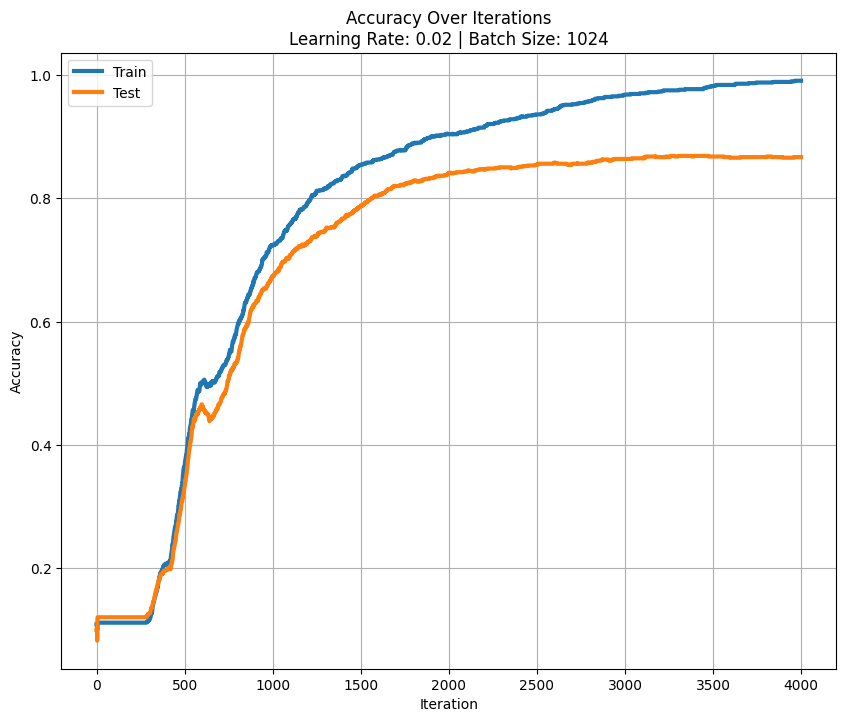

In [117]:
def accuracy_graphic(L, iters, batch, train_l, test_l):

    folder_name = "graphs"
    os.makedirs(folder_name, exist_ok=True)

    fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
    fmt_test = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(iters), train_l, label='Train', **fmt_train)
    ax.plot(range(iters), test_l, label='Test', **fmt_test)
    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy Over Iterations\nLearning Rate: {L} | Batch Size: {batch}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accuracy')

    # Save the figure in the "graphs" folder
    file_path = os.path.join(folder_name, f"accuracy_{L}_{batch}.png")
    plt.savefig(file_path)
    plt.show()

accuracy_graphic(L, num_iterations, batch_size, accuracy_train_l, accuracy_test_l)


Parametros cargados desde 'Weights_&_Bias\model_params_5.npz'.
Dibuja un numero y presiona 'Enter' para predecirlo.
La imagen probablemente es un: 8


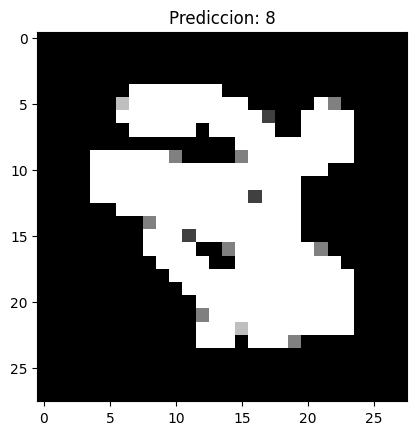

In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

#! Inicializar los parametros de la red neuronal ===============================================

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final precision of test: 67.28515625%, Final Precision of train: 72.36328125%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final precision of test: 90.57617188%, Final Precision of train: 97.94921875%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final precision of test: 44.23828125%, Final Precision of train: 44.04296875%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final precision of test: 90.91796875%, Final Precision of train: 100.00000000% se creo a partir de params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final precision of test: 91.25976562%, Final Precision of train: 100.00000000% se creo a partir de params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final precision of test: 93.89648438%, Final Precision of train: 100.00000000% se creo a partir de params_4
model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final precision of test: 94.87304688%, Final Precision of train: 100.00000000% se creo a partir de params_5

#! Inicializar los parametros de la red neuronal ===============================================

if os.path.exists(model_params_file):
    params = np.load(model_params_file)
    w_1 = params['w_1']
    b_1 = params['b_1']
    w_2 = params['w_2']
    b_2 = params['b_2']
    w_3 = params['w_3']
    b_3 = params['b_3']
    print(f"Parametros cargados desde '{model_params_file}'.")
else:
    raise FileNotFoundError("El archivo de parametros no se encontro.")

relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X): #Esto funcina porque las matricez ya estan hechas en el archivo .npz
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

# Crear una ventana para dibujar
drawing = False  # Controlar el estado de dibujo
last_point = None  # Rastrear el último punto dibujado

# Función de callback para el mouse
def mouse_callback(event, x, y, flags, param):
    global drawing, last_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(canvas, last_point, (x, y), (255, 255, 255), 30)  # Dibujar una línea gruesa blanca
            last_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        last_point = None

# Inicializar un lienzo negro (200x200 píxeles)
canvas = np.zeros((200, 200), dtype=np.uint8)

# Crear ventana y registrar el callback del mouse
cv2.namedWindow("Draw a Number")
cv2.setMouseCallback("Draw a Number", mouse_callback)

print("Dibuja un numero y presiona 'Enter' para predecirlo.")

while True:
    cv2.imshow("Draw a Number", canvas)
    key = cv2.waitKey(1) & 0xFF  # Detectar presiones de teclas
    if key == 13:  # Tecla Enter
        break
    elif key == 27:  # Tecla Esc limpia el lienzo
        canvas.fill(0)

cv2.destroyAllWindows()

# Preprocesar la imagen dibujada para la predicción
def preprocess_image(img):
    img_resized = cv2.resize(img, (20, 20))  # Redimensionar a 20x20 píxeles
    img_with_border = np.zeros((28, 28), dtype=np.uint8)
    img_with_border[4:24, 4:24] = img_resized  # Centrar la imagen redimensionada en un borde de 28x28
    img_with_border = img_with_border / 255.0  # Normalizar a rango 0-1
    img_with_border = img_with_border.flatten()  # Aplanar a un vector (784,)
    return img_with_border

# Procesar y remodelar la imagen
processed_image = preprocess_image(canvas)
processed_image = processed_image.reshape(1, -1)  # Forma como (1, 784) para la predicción

# Predecir el dígito usando la red neuronal
A1, A2, A3 = forward_prop(processed_image.T)  # Asegúrate de transponer para que tenga la forma correcta
prediction = np.argmax(A3, axis=0)  # Obtener la clase con mayor probabilidad
print(f"La imagen probablemente es un: {prediction[0]}")

# Mostrar la imagen procesada
plt.imshow(processed_image.reshape(28, 28), cmap="gray")
plt.title(f"Prediccion: {prediction[0]}")
plt.show()


Parametros cargados desde 'Weights_&_Bias\model_params_5.npz'.
The image is probably a: 0


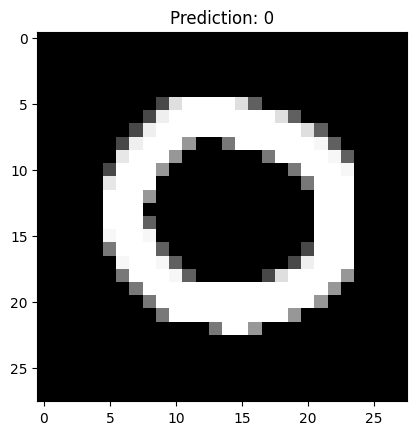

The image is probably a: 1


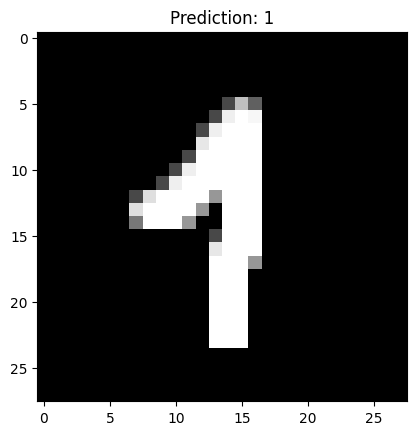

The image is probably a: 2


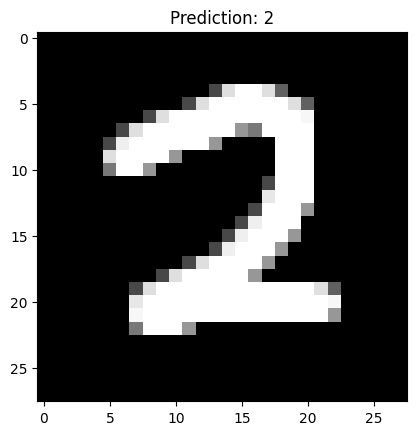

The image is probably a: 3


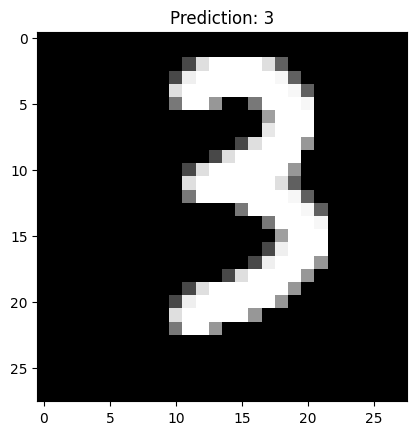

The image is probably a: 4


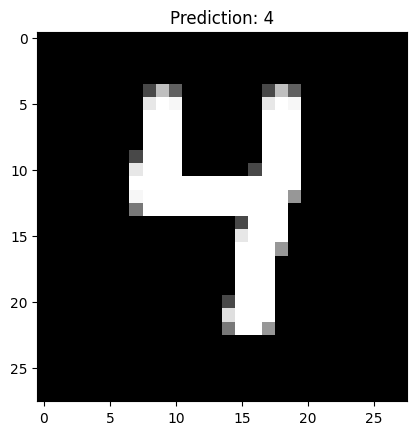

The image is probably a: 5


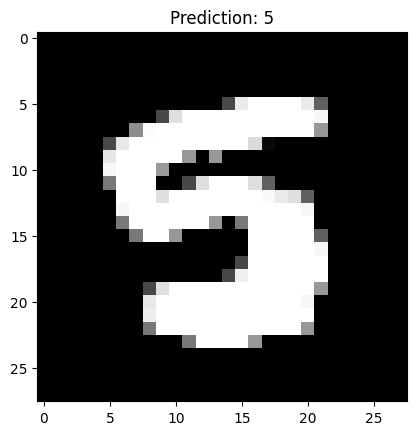

The image is probably a: 6


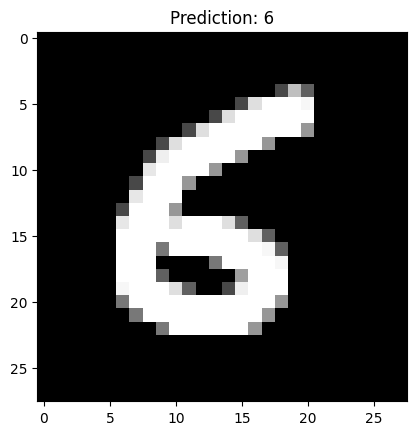

The image is probably a: 7


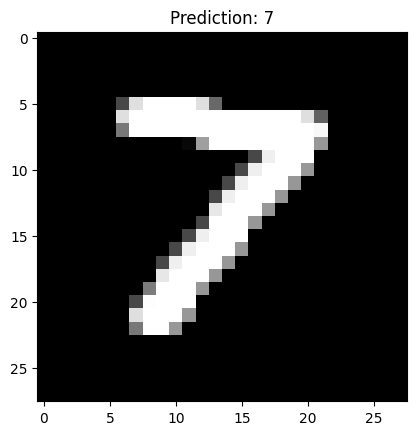

The image is probably a: 8


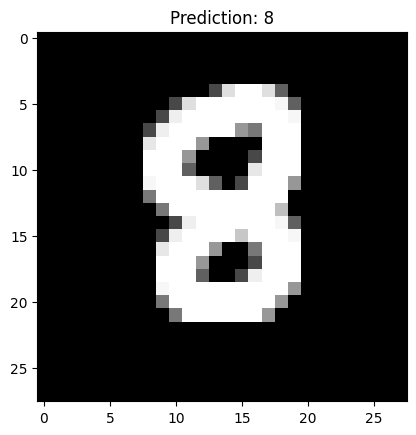

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Función para cargar los parámetros del modelo
def load_model_params(file_path):
    if os.path.exists(file_path):
        try:
            params = np.load(file_path)
            w_1 = params['w_1']
            b_1 = params['b_1']
            w_2 = params['w_2']
            b_2 = params['b_2']
            w_3 = params['w_3']
            b_3 = params['b_3']
            print(f"Parametros cargados desde '{model_params_file}'.")
            return w_1, b_1, w_2, b_2, w_3, b_3
        except Exception as e:
            print(f"Error al cargar parametros: {e}")
            return None
    else:
        print(f"El archivo '{file_path}' no existe.")
        return None

# Funciones de activación
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

# Propagación hacia adelante
def forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

# Función de preprocesamiento de la imagen
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Cargar como escala de grises
    img_resized = cv2.resize(img, (28, 28))      # Redimensionar a 28x28 píxeles
    img_resized = img_resized / 255.0            # Normalizar a rango 0-1
    img_resized = img_resized.flatten()          # Aplanar la imagen a 784 elementos
    return img_resized.reshape(784, 1)           # Asegurarse de que la forma sea (784, 1)

#! Inicializar los parametros de la red neuronal ===============================================

#model_params_file = os.path.join('Weights_&_Bias', 'params_0.npz') # Final precision of test: 67.28515625%, Final Precision of train: 72.36328125%
#model_params_file = os.path.join('Weights_&_Bias', 'params_1.npz') # Final precision of test: 90.57617188%, Final Precision of train: 97.94921875%
#model_params_file = os.path.join('Weights_&_Bias', 'params_2.npz') # Final precision of test: 44.23828125%, Final Precision of train: 44.04296875%
#model_params_file = os.path.join('Weights_&_Bias', 'params_3.npz') # Final precision of test: 90.91796875%, Final Precision of train: 100.00000000% se creo a partir de params_1
#model_params_file = os.path.join('Weights_&_Bias', 'params_4.npz') # Final precision of test: 91.25976562%, Final Precision of train: 100.00000000% se creo a partir de params_3
#model_params_file = os.path.join('Weights_&_Bias', 'params_5.npz') # Final precision of test: 93.89648438%, Final Precision of train: 100.00000000% se creo a partir de params_4
model_params_file = os.path.join('Weights_&_Bias', 'params_6.npz') # Final precision of test: 94.87304688%, Final Precision of train: 100.00000000% se creo a partir de params_5

#! Inicializar los parametros de la red neuronal ===============================================

w_1, b_1, w_2, b_2, w_3, b_3 = load_model_params(model_params_file)

# Predicción usando la red neuronal
for i in range(9):
    image_path = f'digits/digitB{i}.png'
    processed_image = preprocess_image(image_path)

    # Propagación hacia adelante para obtener la predicción
    _, _, A3 = forward_prop(processed_image, w_1, b_1, w_2, b_2, w_3, b_3)
    prediction = np.argmax(A3, axis=0)  # Obtener la clase con la probabilidad más alta

    print(f'The image is probably a: {prediction[0]}')

    # Visualizar la imagen procesada
    plt.imshow(processed_image.reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {prediction[0]}')
    plt.show()
